In [ ]:
"""
- Extract tweets from twitter which have the keywords - 'Coronavirus' or 'COVID'.
- Employ textblob and NLTK's SentimentIntensityAnalyser to label the sentiments.
- Preprocess the text to remove links, twitter handles and stopwords.
- visualise using WordClouds
- Train different models to predict the sentiment.

"""

In [71]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import warnings
# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer  
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob

# Extracting Tweets

In [5]:
consumer_key = "xxxx" 
consumer_secret = "xxxx"
access_key = "xxxx"
access_secret = "xxxx"

In [6]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_key, access_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print('Error: Tweeter Authentication Failed - ' + str(e))

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        #return tweets with ID higher than since_id and id lower than max_id
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry, tweet_mode='extended')
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry, tweet_mode='extended', 
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry, tweet_mode='extended', 
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry, tweet_mode='extended', 
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                
                for tweet in new_tweets:
                    parsed_tweet = {} 
                    if 'retweeted_status' in dir(tweet):
                        parsed_tweet['tweets'] = tweet.retweeted_status.full_text
                    else:
                        parsed_tweet['tweets'] = tweet.full_text
                        
                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                
    
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [7]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('Coronavirus Covid', maxTweets=10000)
print('tweets_df Shape - ', tweets_df.shape)
tweets_df.head()

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1097 tweets
Downloaded 1197 tweets
Downloaded 1297 tweets
Downloaded 1397 tweets
Downloaded 1497 tweets
Downloaded 1597 tweets
Downloaded 1697 tweets
Downloaded 1797 tweets
Downloaded 1897 tweets
Downloaded 1997 tweets
Downloaded 2097 tweets
Downloaded 2197 tweets
Downloaded 2297 tweets
Downloaded 2397 tweets
Downloaded 2496 tweets
Downloaded 2596 tweets
Downloaded 2696 tweets
Downloaded 2796 tweets
Downloaded 2896 tweets
Downloaded 2996 tweets
Downloaded 3096 tweets
Downloaded 3196 tweets
Downloaded 3296 tweets
Downloaded 3396 tweets
Downloaded 3496 tweets
Downloaded 3596 tweets
Downloaded 3696 tweets
Downloaded 3796 tweets
Downloaded 3896 tweets
Downloaded 3996 tweets
Downloaded 4096 tweets
Downloaded 4196 tweets
Downloaded 4296 tweets
Downloaded 4396 twee

,tweets
0,Poor air quality has been linked to Covid-19 i...
1,⁦@GMB⁩ so the man who berated sports stars &am...
2,The government is running live webinars on the...
3,"UPDATE: Russia's coronavirus tally rose by 10,..."
4,This week HMRC will start contacting customers...


In [8]:
#save to csv file
tweets_df.to_csv(r'rawTweets-04May.csv', index = False)

In [9]:
#making a copy of the dataframe
tweets_df_copy = tweets_df.copy()

# Sentiment Analysis

In [167]:
# Using NITK Sentiment Analyser (SIA)
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# Using textblob
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [27]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,3372
neg,1290


In [28]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,4138
neg,524


In [168]:
# we will use SIA as it has identified more negative tweets
# adding the sentiment to a new column 
tweets_df['sentiment_sia'] = sentiments_using_SIA
tweets_df.head()

,tweets,sentiment_sia
0,Poor air quality has been linked to Covid-19 i...,neg
1,⁦@GMB⁩ so the man who berated sports stars &am...,pos
2,The government is running live webinars on the...,pos
3,"UPDATE: Russia's coronavirus tally rose by 10,...",pos
4,This week HMRC will start contacting customers...,pos


In [169]:
#making a copy of the dataframe
tweets_df_copy1 = tweets_df.copy()

# Text Preprocessing

In [170]:
#tweets_df['tidy_tweets'] will contain tweets after removing links and handles (@names)
#tweets_df['absolute_tidy_tweets'] will contain tweets after removing punctuation. Used for wordcloud
#tweets_df['stemmed_tweets'] will hold stemmed tweets. Used for bag of words, TF-IDF  and to predict the sentiment

temp = tweets_df.iloc[:,0].values

tweets_df['tidy_tweets'] = temp
tweets_df['absolute_tidy_tweets'] = temp
tweets_df['stemmed_tweets'] = temp

print('tweets_df Shape - ', tweets_df.shape)
tweets_df.head()

tweets_df Shape -  (4662, 5)


,tweets,sentiment_sia,tidy_tweets,absolute_tidy_tweets,stemmed_tweets
0,Poor air quality has been linked to Covid-19 i...,neg,Poor air quality has been linked to Covid-19 i...,Poor air quality has been linked to Covid-19 i...,Poor air quality has been linked to Covid-19 i...
1,⁦@GMB⁩ so the man who berated sports stars &am...,pos,⁦@GMB⁩ so the man who berated sports stars &am...,⁦@GMB⁩ so the man who berated sports stars &am...,⁦@GMB⁩ so the man who berated sports stars &am...
2,The government is running live webinars on the...,pos,The government is running live webinars on the...,The government is running live webinars on the...,The government is running live webinars on the...
3,"UPDATE: Russia's coronavirus tally rose by 10,...",pos,"UPDATE: Russia's coronavirus tally rose by 10,...","UPDATE: Russia's coronavirus tally rose by 10,...","UPDATE: Russia's coronavirus tally rose by 10,..."
4,This week HMRC will start contacting customers...,pos,This week HMRC will start contacting customers...,This week HMRC will start contacting customers...,This week HMRC will start contacting customers...


In [171]:
#removing stopwords
stop_words = set(stopwords.words("english"))

#removing common words and words from other languages
new_words = ('coronavirus', 'covid', 'corona')
new_stopwords=stop_words.union(new_words)

In [172]:
#for stemming the words 
porter = PorterStemmer()
#to remove words from other languages
words = set(nltk.corpus.words.words())

for i in range(len(tweets_df['tweets'])):  
    
    #remove links
    tweet = re.sub(r'http\S+', '', tweets_df['tweets'][i])
    
    #remove '@name'
    tweet = re.sub(r'@\S+', '', tweet)          
    
    #remove words from different language
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha()) 
    
    tweets_df['tidy_tweets'][i] = tweet 
    
    #remove punctuation
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    #to lower case
    tweet = tweet.lower()
    
    #split it into words
    tweet = word_tokenize(tweet)
    
    #removing stopwords
    tweet = [word for word in tweet if not word.lower() in new_stopwords]
    
    #joining all words back into a string
    tweet = ' '.join(tweet)
    
    tweets_df['absolute_tidy_tweets'][i] = tweet 
    
    #stem the words
    tweet = [porter.stem(word) for word in word_tokenize(tweet)]
    
    #joining all words back into a string
    tweet = ' '.join(tweet)
    
    tweets_df['stemmed_tweets'][i] = tweet 

In [173]:
print('tweets_df Shape - ', tweets_df.shape)
tweets_df.head()

tweets_df Shape -  (4662, 5)


,tweets,sentiment_sia,tidy_tweets,absolute_tidy_tweets,stemmed_tweets
0,Poor air quality has been linked to Covid-19 i...,neg,Poor air quality been linked to Covid - 19 . P...,poor air quality linked president trump still ...,poor air qualiti link presid trump still limit...
1,⁦@GMB⁩ so the man who berated sports stars &am...,pos,⁦ so the man who sports & ; for getting tested...,man sports getting tested ahead staff even sho...,man sport get test ahead staff even show link ...
2,The government is running live webinars on the...,pos,The government is running live on the Self - e...,government running live self employment income...,govern run live self employ incom support sche...
3,"UPDATE: Russia's coronavirus tally rose by 10,...",pos,"UPDATE : Russia ' s tally rose by 10 , 581 to ...",update russia tally rose past response,updat russia talli rose past respons
4,This week HMRC will start contacting customers...,pos,This week will start who may be eligible to ap...,week start may eligible apply self employment ...,week start may elig appli self employ incom su...


In [174]:
#removing tweets with empty text
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']

#removing duplicates, if any
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)

tweets_df = tweets_df.reset_index(drop=True)

print('tweets_df Shape - ', tweets_df.shape)
tweets_df.head()

tweets_df Shape -  (4617, 5)


,tweets,sentiment_sia,tidy_tweets,absolute_tidy_tweets,stemmed_tweets
0,Poor air quality has been linked to Covid-19 i...,neg,Poor air quality been linked to Covid - 19 . P...,poor air quality linked president trump still ...,poor air qualiti link presid trump still limit...
1,⁦@GMB⁩ so the man who berated sports stars &am...,pos,⁦ so the man who sports & ; for getting tested...,man sports getting tested ahead staff even sho...,man sport get test ahead staff even show link ...
2,The government is running live webinars on the...,pos,The government is running live on the Self - e...,government running live self employment income...,govern run live self employ incom support sche...
3,"UPDATE: Russia's coronavirus tally rose by 10,...",pos,"UPDATE : Russia ' s tally rose by 10 , 581 to ...",update russia tally rose past response,updat russia talli rose past respons
4,This week HMRC will start contacting customers...,pos,This week will start who may be eligible to ap...,week start may eligible apply self employment ...,week start may elig appli self employ incom su...


# Wordclouds

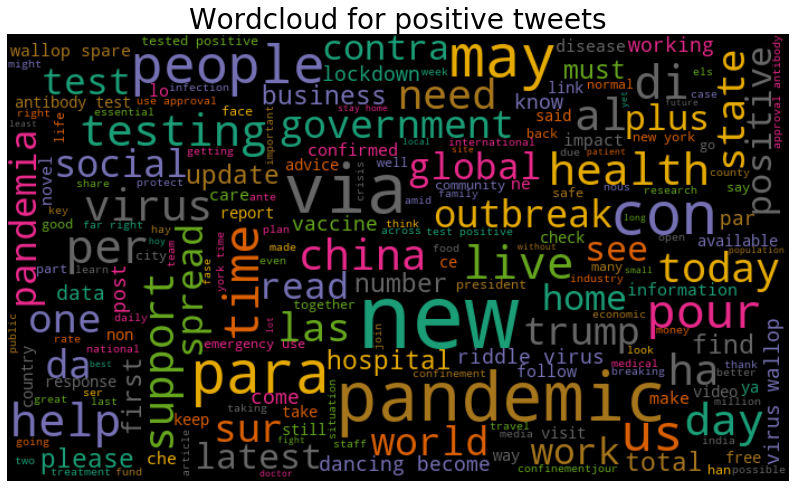

In [185]:
textall = ' '.join(text for text in tweets_df['absolute_tidy_tweets'][tweets_df['sentiment_sia'] == 'pos'])

wordcloud = WordCloud(width=700, height=400, max_font_size=80, colormap='Dark2').generate(textall)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud for positive tweets', fontsize = 28)
plt.axis('off')
plt.show()

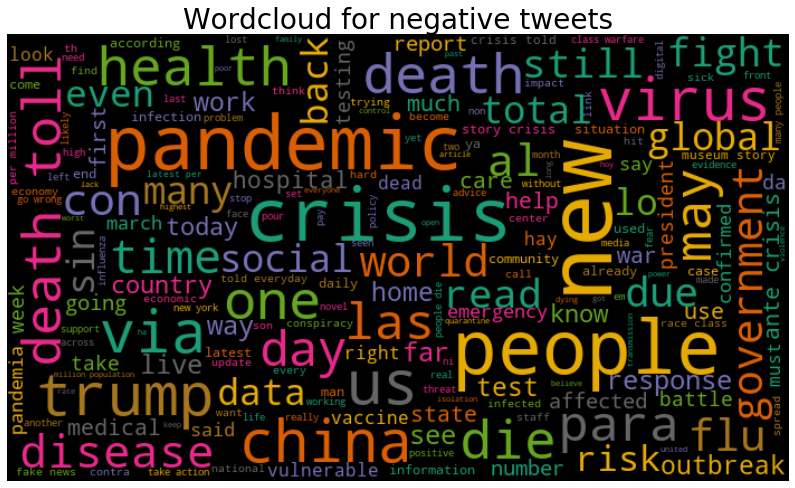

In [178]:
textall = ' '.join(text for text in tweets_df['absolute_tidy_tweets'][tweets_df['sentiment_sia'] == 'neg'])

wordcloud = WordCloud(width=700, height=400, max_font_size=80, colormap='Dark2').generate(textall)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud for negative tweets', fontsize = 28)
plt.axis('off')
plt.show()

# Feature Extraction

In [137]:
# Bag of Words features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df['stemmed_tweets'])

In [136]:
# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df['stemmed_tweets'])

# Classification

In [147]:
#trying 4 different classifiers - Logistic Regression, SVM, Decision Tree, Random Forest
def classification(X_train, X_test, y_train, y_test):
    
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train,y_train_tb)
    y_pred=classifier.predict(X_test)
    print("Logistic Regression: Accuracy:",accuracy_score(y_test_tb, y_pred))
    print("Logistic Regression: F1 Score:",f1_score(y_test_tb, y_pred))

    classifier = SVC(kernel = 'rbf', random_state=42)
    classifier = classifier.fit(X_train,y_train_tb)
    y_pred=classifier.predict(X_test)
    print("SVM: Accuracy:",accuracy_score(y_test_tb, y_pred))
    print("SVM: F1 Score:",f1_score(y_test_tb, y_pred))

    classifier = DecisionTreeClassifier(random_state=42)
    classifier = classifier.fit(X_train,y_train_tb)
    y_pred=classifier.predict(X_test)
    print("Decision Tree: Accuracy:",accuracy_score(y_test_tb, y_pred))
    print("Decision Tree: F1 Score:",f1_score(y_test_tb, y_pred))

    classifier = RandomForestClassifier(n_estimators=50, random_state=42)
    classifier = classifier.fit(X_train,y_train_tb)
    y_pred=classifier.predict(X_test)
    print("Random Forest: Accuracy:",accuracy_score(y_test_tb, y_pred))
    print("Random Forest: F1 Score:",f1_score(y_test_tb, y_pred))

In [153]:
#Sentiment Analysis using Bag of Words features
X = bow_word_feature.toarray()
# neg:0 ; pos:1
y_sia = tweets_df['sentiment_sia'].apply(lambda x: 0 if x=='neg' else 1)

X_train, X_test, y_train_sia, y_test_sia = train_test_split(X, y_sia, test_size=0.2, random_state=42)

In [154]:
print('Sentiment Analysis using Bag of Words features for SIA sentiments')
classification(X_train, X_test, y_train_sia, y_test_sia)

Sentiment Analysis using Bag of Words features for SIA sentiments
Logistic Regression: Accuracy: 0.9177489177489178
Logistic Regression: F1 Score: 0.955451348182884
SVM: Accuracy: 0.8993506493506493
SVM: F1 Score: 0.9464594127806564
Decision Tree: Accuracy: 0.9112554112554112
Decision Tree: F1 Score: 0.9500609013398295
Random Forest: Accuracy: 0.9253246753246753
Random Forest: F1 Score: 0.9590017825311943


In [159]:
#Sentiment Analysis using TF-IDF features 
X = tfidf_word_feature.toarray()
# neg:0 ; pos:1
y_sia = tweets_df['sentiment_sia'].apply(lambda x: 0 if x=='neg' else 1)

X_train, X_test, y_train_sia, y_test_sia = train_test_split(X, y_sia, test_size=0.2, random_state=42)

In [160]:
print('Sentiment Analysis using TF-IDF features for SIA sentiments')
classification(X_train, X_test, y_train_sia, y_test_sia)

Sentiment Analysis using TF-IDF features for SIA sentiments
Logistic Regression: Accuracy: 0.895021645021645
Logistic Regression: F1 Score: 0.9442848937392303
SVM: Accuracy: 0.9015151515151515
SVM: F1 Score: 0.947550432276657
Decision Tree: Accuracy: 0.9047619047619048
Decision Tree: F1 Score: 0.9464068209500608
Random Forest: Accuracy: 0.9166666666666666
Random Forest: F1 Score: 0.9547856723429243


In [ ]:
#both the features produce similar results in all models